In [1]:
import re
from collections import defaultdict
from collections import Counter
import operator
from stop_words import get_stop_words
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import math

import networkx as nx
from stemming.porter2 import stem

wordslist = []
pattern = re.compile(r'\W+')
save_file = open('../data/USJobFeature.json', 'a')
with open('../data/USJobText_nogeo.json') as job_text:
    for line in job_text:
        line = line.split(None)
        wordsline = [''.join(pattern.split(x)).lower() for x in line if x.startswith('#')]
        wordsline = [x for x in wordsline if x!='']
        wordslist = wordslist + wordsline
        save_file.write(' '.join(wordsline) + '\n')
        #wordslist = list(set().union(wordslist,wordsline))

save_file.close()

stemwords = [stem(word) for word in wordslist]

cc = Counter(stemwords).most_common(300)[:100]
keys = list(map(lambda x: x[0], cc))
counts = list(map(lambda x: x[1], cc))
#print keys
#keys = list(set(wordslist))
nodes = keys
edges = []
       
com = defaultdict(lambda : defaultdict(int))
com_np = np.zeros((len(keys), len(keys)))
W = np.zeros((len(keys), len(keys)))
D = np.zeros((len(keys), len(keys)))
 
# f is the file pointer to the JSON data set
with open('../data/USJobText_nogeo.json') as f:
    for line in f: 
        line = line.split(None)
        terms_only = [''.join(pattern.split(x)).lower() for x in line if x.startswith('#')]
        terms_only = [x for x in terms_only if x!='']
        terms_only = list(set(terms_only))
     
        # Build co-occurrence matrix
        for i in range(len(terms_only)-1):            
            for j in range(i+1, len(terms_only)):
                stemwordi = stem(terms_only[i])
                stemwordj = stem(terms_only[j])
                if stemwordi in keys and stemwordj in keys:
                    #row = keys.index(terms_only[i])
                    #col = keys.index(terms_only[j])
                    #w1, w2 = sorted([terms_only[i], terms_only[j]])                
                    #if w1 != w2:
                    row, col = sorted([keys.index(stemwordi), keys.index(stemwordj)])
                    com_np[row][col] += 1
                    com_np[col][row] += 1
                    if not (keys[row], keys[col]) in edges:
                        edges.append((keys[row], keys[col]))

## W/D
W = com_np
#D = np.diag(W.sum)

com_np_list = com_np.tolist()
#com_norm = np.zeros_like(com_np)
h = []
com_norm = []
com_np_new = []
clusterwords = []
selfwords = []
for i in range(len(keys)):
    if not sum(com_np_list[i]) == 0:
        com_np_temp = com_np_list[i]
        com_np_temp[i] = sum(com_np_temp) / float(sum([1 for x in com_np_temp if x > 0]))
        com_np_new.append(com_np_temp)
        com_norm_temp = [x/float(sum(com_np_temp)) for x in com_np_temp]
        com_norm.append(com_norm_temp)
        h.append(stats.entropy(com_norm_temp)) #/ counts[i]
        clusterwords.append(keys[i])
        #for j in range(i+1, len(keys)):
        #    G.add_edge(keys[i], keys[j], weight = 1)
    else:
        h.append(0)
        selfwords.append(keys[i])
        
print(sum(h)/len(h))


1.59506094209


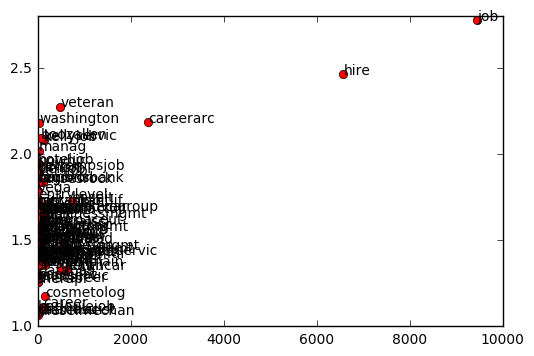

In [2]:
n = 0

logcounts = [math.log(x) for x in counts]
logcounts_norm = [ x/max(logcounts) for x in logcounts ]
h2 = [x**2 for x in h]
hexp = [math.exp(x) for x in h]
hexp_norm = [x/max(hexp) for x in hexp]
plt.plot( counts[n:], h[n:],'ro')
#plt.show()
# loop through each x,y pair

for i,j in zip(counts[n:],h[n:]):
    corr = 0#-0.05 # adds a little correction to put annotation in marker's centrum
    plt.annotate(str(keys[n]),  xy=(i + corr, j + corr))
    n += 1

#ax[1].imshow(com_icount)
plt.show()

#from networkx.algorithms import approximation as apxa
#ks = apxa.k_components(G)

# reverse com

In [3]:
#G = nx.Graph()
cluster1 = [keys[i] for i in range(len(keys)) if h[i]<2 and counts[i]>200]
cluster2 = [keys[i] for i in range(len(keys)) if h[i]<2 and counts[i]<200]
'''
for i in range(len(keys)):
    if h[i] < 2:
        if counts[i]<200:
        #    cluster1.append(keys[i])
        #else:
            if not sum(com_np_list[i]) == 0:
                cluster2.append(keys[i])

G.add_nodes_from(cluster1, bipartite=0)
for i in range(len(cluster1)):
    for j in range(len(cluster2)):
        if com_np[i][j] > 0:
            G.add_node(keys[j], bipartite=1)
            G.add_edge(keys[i], keys[j], weight = 1)
'''

'\nfor i in range(len(keys)):\n    if h[i] < 2:\n        if counts[i]<200:\n        #    cluster1.append(keys[i])\n        #else:\n            if not sum(com_np_list[i]) == 0:\n                cluster2.append(keys[i])\n\nG.add_nodes_from(cluster1, bipartite=0)\nfor i in range(len(cluster1)):\n    for j in range(len(cluster2)):\n        if com_np[i][j] > 0:\n            G.add_node(keys[j], bipartite=1)\n            G.add_edge(keys[i], keys[j], weight = 1)\n'

In [4]:
vec1 = np.zeros((len(cluster1), len(cluster2)))
for c1 in cluster1:
    for c2 in cluster2:
        i = keys.index(c1)
        j = keys.index(c2)
        ci = cluster1.index(c1)
        cj = cluster2.index(c2)
        vec1[ci][cj] = com_np[i][j]

In [6]:
cluster1

['hospit',
 'retail',
 'nurs',
 'healthcar',
 'sale',
 'transport',
 'customerservic',
 'it']

In [7]:
vec2 = np.zeros((len(cluster2), len(cluster1)))
for c1 in cluster1:
    for c2 in cluster2:
        i = keys.index(c1)
        j = keys.index(c2)
        ci = cluster1.index(c1)
        cj = cluster2.index(c2)
        vec2[cj][ci] = com_np[j][i]

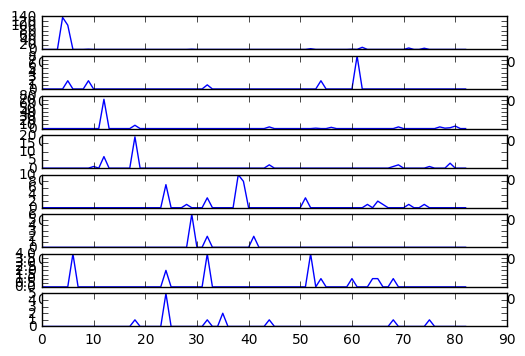

In [5]:
fig, ax = plt.subplots(vec1.shape[0])
for i in range(vec1.shape[0]):
    ax[i].plot(vec1[i])
plt.show()

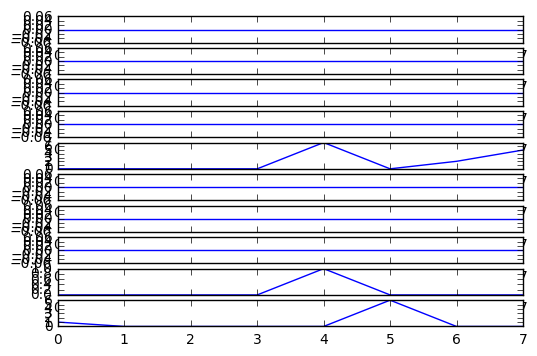

['supplychain',
 'physician',
 'art',
 'healthwelfar',
 'delljob',
 'fastcasu',
 'legal',
 'internship',
 'milspous',
 'driver']

In [10]:
offset = 20
fig, ax = plt.subplots(10)
for i in range(10):
    ax[i].plot(vec2[i+offset])
plt.show()
cluster2[offset:10+offset]

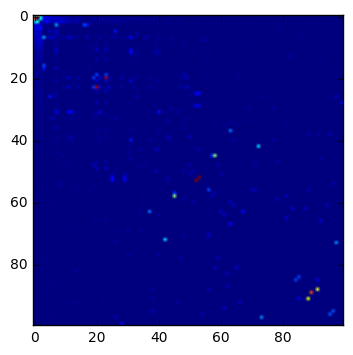

In [65]:
com_icount = np.zeros_like(com_np)

for i in range(len(keys)):
    for j in range(len(keys)):
        if com_np[i][j] > 0:
            max_count = max(counts[i], counts[j])
            com_icount[i][j] = com_np[i][j] / max_count

plt.imshow(com_icount)
plt.show()